In [1]:
import pandas as pd
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import io
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(keras.backend.backend())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-04-04 20:40:52.561442: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 20:40:52.728886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 20:40:53.271162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow
Num GPUs Available:  0


In [2]:
dataframe = pd.read_csv('../data/labels-map-proj-v3.txt', delimiter=' ', header=None)
dataframe.columns = ['file_names','labels']
display(dataframe)

,file_names,labels
0,ESP_011623_2100_RED-0069.jpg,0
1,ESP_011623_2100_RED-0069-r90.jpg,0
2,ESP_011623_2100_RED-0069-r180.jpg,0
3,ESP_011623_2100_RED-0069-r270.jpg,0
4,ESP_011623_2100_RED-0069-fh.jpg,0
...,...,...
73026,PSP_010461_1845_RED-0032-r180.jpg,0
73027,PSP_010461_1845_RED-0032-r270.jpg,0
73028,PSP_010461_1845_RED-0032-fh.jpg,0
73029,PSP_010461_1845_RED-0032-fv.jpg,0


In [3]:
total_rows = len(dataframe)
part_size = 10000
num_parts = total_rows // part_size
if total_rows % part_size != 0:
    num_parts += 1
indices = np.array_split(dataframe.index, num_parts)
data_parts = []
for idx in indices:
    data_parts.append(dataframe.loc[idx])

In [4]:
# TODO: nicht den ganzen datensatz direkt reinladen und in einer einzelnen datenstruktur speichern. Nach und Nach Laden und direkt ins Training geben.
# Dazu am besten den label datensatz zerteilen. 
first_dataframe = data_parts[0]  # TODO: change to for loop and use method
amount = first_dataframe.shape[0]
display(first_dataframe)
preprocessed_images = []
for i in range(amount):
    filname = dataframe['file_names'].iloc[i]
    with open('../data/map-proj-v3/'+filname, 'rb') as file:
        img_bytes = file.read()
        img = image.load_img(io.BytesIO(img_bytes))
        img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)  # Normalize pixel values
    preprocessed_images.append(img_array)


,file_names,labels
0,ESP_011623_2100_RED-0069.jpg,0
1,ESP_011623_2100_RED-0069-r90.jpg,0
2,ESP_011623_2100_RED-0069-r180.jpg,0
3,ESP_011623_2100_RED-0069-r270.jpg,0
4,ESP_011623_2100_RED-0069-fh.jpg,0
...,...,...
9124,ESP_012687_1930_RED-0092-r270.jpg,3
9125,ESP_012687_1930_RED-0092-fh.jpg,3
9126,ESP_012687_1930_RED-0092-fv.jpg,3
9127,ESP_012687_1930_RED-0092-brt.jpg,3


9129


(9129, 227, 227, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


227


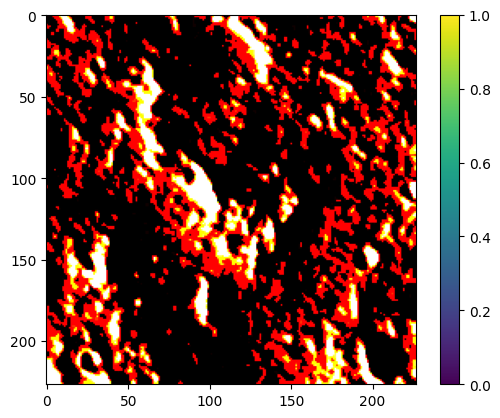

In [5]:
preprocessed_images = np.array(preprocessed_images)
print(len(preprocessed_images))
display(preprocessed_images.shape)
print(len(preprocessed_images[0]))

plt.figure()
plt.imshow(preprocessed_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
num_classes=len(data_parts[0]['labels'].unique())
print('Number of unique Labels: ' + str(num_classes))

Number of unique Labels: 8


In [7]:
labels_array = first_dataframe['labels'].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, labels_array, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Batch the dataset
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(227, 227, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 227, 227, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6595712)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │    52,765,704 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,766,216 (201.29 MB)

 Trainable params: 52,766,216 (201.29 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=1)


183/183 ━━━━━━━━━━━━━━━━━━━━ 132s 716ms/step - accuracy: 0.7232 - loss: 4478.7554 - val_accuracy: 0.8316 - val_loss: 690.8611


In [10]:
evaluation = model.evaluate(test_dataset)

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.8245 - loss: 671.6299
